# Long short-term memory Forecasting

## Inhalt

1. **Datenexploration und Vorverarbeitung**: Zuerst wird ein Pandas DataFrame mit historischen Aktienkursdaten erstellt. Die Daten werden so gefiltert, dass nur die Daten des letzten Monats betrachtet werden und bestimmte Spalten (Close, High, Low, Open) für die Analyse ausgewählt werden.

2. **Datenvisualisierung**: Die ausgewählten Spalten werden in einem Liniendiagramm visualisiert, um Trends und Muster in den Daten zu identifizieren.

3. **Daten vorbereitung für das Modelltraining**: Die Daten werden auf einen Bereich zwischen 0 und 1 skaliert. Dies ist ein üblicher Schritt bei der Verwendung von Neuronalen Netzwerken, um sicherzustellen, dass alle Eingaben in einem ähnlichen Bereich liegen. Danach werden die Daten in Trainings- und Testdatensätze aufgeteilt und in die für ein LSTM (Long Short-Term Memory) Modell erforderliche Form gebracht.

4. **Modell Erstellung und Training**: Ein LSTM Modell wird mit Keras erstellt und auf den Trainingsdaten trainiert.

5. **Modell Evaluierung**: Der Trainingsverlauf des Modells wird visualisiert und die Vorhersagen des Modells auf den Testdaten werden mit den tatsächlichen Werten verglichen.

6. **Vorhersage der zukünftigen Aktienkurse**: Das trainierte Modell wird verwendet, um Vorhersagen für die nächsten 30 Tage zu treffen, die dann in den DataFrame eingefügt werden.

7. **Datenspeicherung in der Datenbank**: Die neuen Vorhersagen werden in eine bestehende SQL Server-Datenbank geschrieben. Hierbei wird darauf geachtet, Duplikate zu vermeiden und nur neue Vorhersagen hinzuzufügen, die noch nicht in der Datenbank vorhanden sind.

Es werden verschiedene Bibliotheken und Pakete importiert, die für die Datenanalyse und den Aufbau eines Deep-Learning-Modells erforderlich sind

---

In diesem Code wird eine Reihe von Python-Bibliotheken importiert, die für das Training eines LSTM-Neuronale-Netzwerk-Modells (Long Short-Term Memory) nützlich sind. Dies sind die Hauptkomponenten und deren Funktionen:

1. **math, numpy und pandas**: Diese Bibliotheken werden für mathematische Berechnungen und Datenmanipulationen verwendet. Sie ermöglichen das Arbeiten mit Daten in einer strukturierten Weise.

2. **datetime**: Diese Bibliothek wird für die Arbeit mit Daten und Zeitstempeln verwendet.

3. **pandas.plotting.register_matplotlib_converters, matplotlib und seaborn**: Dies sind Visualisierungsbibliotheken, die zum Plotten und Anzeigen von Daten und Analyseergebnissen verwendet werden.

4. **tensorflow und tensorflow.keras**: Tensorflow ist eine weit verbreitete Bibliothek für das maschinelle Lernen und wird hier verwendet, um ein LSTM-Modell zu erstellen und zu trainieren. Keras ist eine High-Level-API von Tensorflow, die das Erstellen und Trainieren von Modellen erleichtert. LSTM, Dense und Dropout sind Schichten, die in einem Neuronalen Netzwerk verwendet werden, und EarlyStopping ist eine Technik, um das Training zu stoppen, wenn das Modell nicht mehr besser wird.

5. **sklearn.metrics**: Diese Bibliothek enthält Funktionen zur Bewertung der Modellperformance. Die Funktionen mean_absolute_error und mean_squared_error werden verwendet, um den Fehler des Modells zu berechnen.

6. **sklearn.preprocessing**: RobustScaler und MinMaxScaler sind Techniken zur Datennormalisierung, die oft in maschinellen Lernmodellen verwendet werden, um die Performance zu verbessern.

Am Ende des Codes überprüft der Anwender die Tensorflow-Version und die verfügbaren physischen Geräte (in diesem Fall CPU).

Das ist im Grunde eine Vorbereitungsphase, in der alle notwendigen Werkzeuge importiert werden. Es ist sehr wahrscheinlich, dass nach diesem Abschnitt der Datenimport, die Vorverarbeitung und schließlich das Training des LSTM-Modells folgen werden.

In [1]:
import math # Mathematische Funktionen
import numpy as np # Grundlegendes Paket für wissenschaftliches Rechnen mit Python
import pandas as pd # Zusätzliche Funktionen zur Analyse und Manipulation von Daten
from datetime import date, timedelta, datetime # Datum-Funktionen
from pandas.plotting import register_matplotlib_converters # Diese Funktion fügt Plotting-Funktionen für Kalenderdaten hinzu
import matplotlib.pyplot as plt # Wichtiges Paket für Visualisierung - wir verwenden es, um Marktdaten zu plotten
import matplotlib.dates as mdates # Datum-Formatierung
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Pakete zur Messung der Modellleistung / Fehler
from tensorflow.keras import Sequential # Deep-Learning-Bibliothek, die für neuronale Netzwerke verwendet wird
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep-Learning-Klassen für wiederkehrende und reguläre dicht verbundene Schichten
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping während des Modelltrainings
from sklearn.preprocessing import RobustScaler, MinMaxScaler # Dieser Scaler entfernt den Median und skaliert die Daten gemäß dem Quantilsbereich, um die Preisdaten zu normalisieren
import seaborn as sns # Visualisierung
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

# Überprüfen der TensorFlow-Version und der Anzahl verfügbarer GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('CPU')

Tensorflow Version: 2.10.0


Zunächst wird eine Verbindung zu einer SQL Server-Datenbank hergestellt und es werden Aktiendaten für ein spezifisches Unternehmen extrahiert. Die relevanten Daten werden in einem Dataframe gespeichert. Zur weiteren Bearbeitung wird eine Transformation der Daten angewandt.

In [2]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2020-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "AAPL"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())

          Date Company Type        Open        High         Low       Close  \
750 2023-06-26    AAPL  ACT  186.830002  188.050003  185.229996  185.270004   
751 2023-06-27    AAPL  ACT  185.889999  188.389999  185.669998  188.059998   
752 2023-06-28    AAPL  ACT  187.929993  189.899994  187.600006  189.250000   
753 2023-06-29    AAPL  ACT  189.080002  190.070007  188.940002  189.589996   
754 2023-06-30    AAPL  ACT  191.630005  194.479996  191.259995  193.970001   

       Volume  
750  48088700  
751  50730800  
752  51216800  
753  46347300  
754  85069600  


Diese Schritte dienen dazu, bestimmte Spalten aus dem DataFrame zu entfernen und die Indexierung auf das Datum festzulegen. Dadurch wird der DataFrame besser für weitere Analyse- und Visualisierungszwecke geeignet.

In [3]:
df = data #Unterscheidung zu Arima
df.drop("Company", axis=1, inplace=True)
df.drop("Type", axis=1, inplace=True)
df.set_index("Date", inplace=True)

In [4]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-01,91.279999,91.839996,90.977501,91.027496,110737200
2020-07-02,91.962502,92.617500,90.910004,91.027496,114041600
2020-07-06,92.500000,93.945000,92.467499,93.462502,118655600
2020-07-07,93.852501,94.654999,93.057503,93.172501,112424400
2020-07-08,94.180000,95.375000,94.089996,95.342499,117092000
...,...,...,...,...,...
2023-06-26,186.830002,188.050003,185.229996,185.270004,48088700
2023-06-27,185.889999,188.389999,185.669998,188.059998,50730800
2023-06-28,187.929993,189.899994,187.600006,189.250000,51216800


Es folgt die Erstellung eines Liniendiagramms, das die Verläufe der Spalten "Close", "High", "Low" und "Open" visualisiert.

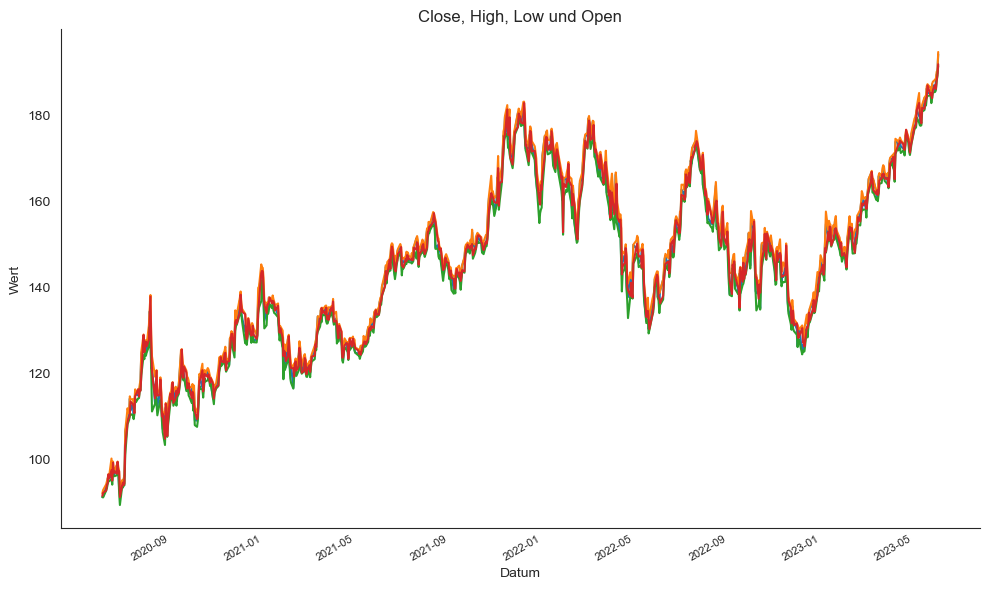

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Annahme: df ist der DataFrame, der die Daten enthält

# Auswahl der gewünschten Spalten
df_plot = df[['Close', 'High', 'Low', 'Open']].copy()

# Plot Line Chart
fig, ax = plt.subplots(figsize=(10, 6))
for column in df_plot.columns:
    sns.lineplot(data=df_plot[column], ax=ax)

ax.set_xlabel('Datum')
ax.set_ylabel('Wert')
ax.set_title('Close, High, Low und Open')

ax.tick_params(axis="x", rotation=30, labelsize=8, length=0)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.show()


Zur besseren Veranschaulichung wird ein weiteres Liniendiagramm erzeugt, das die Verläufe der Spalten "Close", "High", "Low" und "Open" für den letzten Monat visualisiert. Dabei werden unterschiedliche Farben, Linienstärken und Linienstile verwendet, um die einzelnen Linien im Diagramm zu unterscheiden.

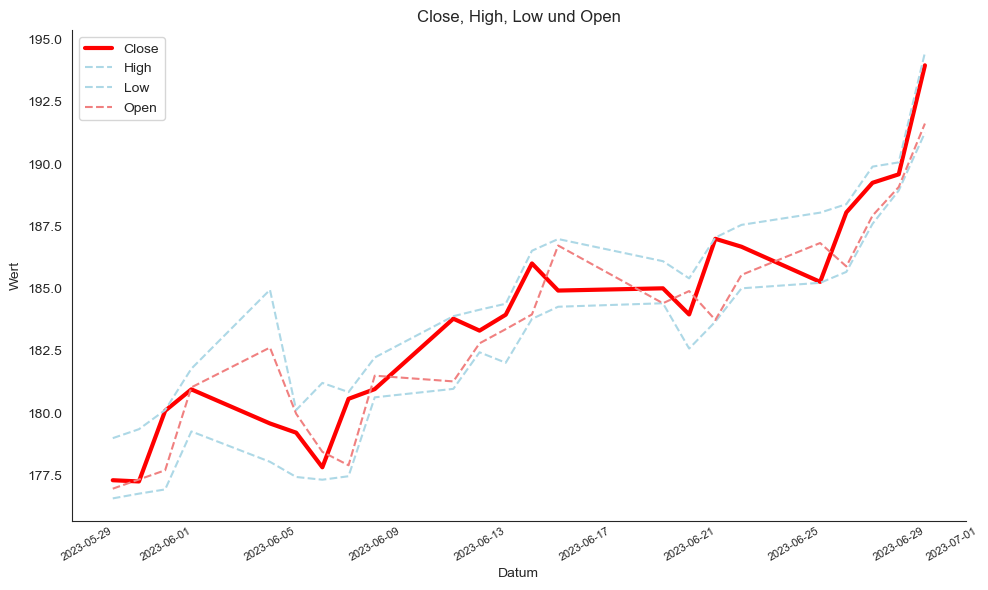

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Annahme: df ist der DataFrame, der die Daten enthält

# Filtern des DataFrame auf den letzten Monat
df_last_month = df.loc[df.index >= df.index.max() - pd.DateOffset(months=1)]

# Auswahl der gewünschten Spalten
df_plot = df_last_month[['Close', 'High', 'Low', 'Open']].copy()

# Plot Line Chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_plot['Close'], ax=ax, color='red', linewidth=3, label='Close')
sns.lineplot(data=df_plot['High'], ax=ax, color='lightblue', linewidth=1.5, linestyle='dashed', label='High')
sns.lineplot(data=df_plot['Low'], ax=ax, color='lightblue', linewidth=1.5, linestyle='dashed', label='Low')
sns.lineplot(data=df_plot['Open'], ax=ax, color='lightcoral', linewidth=1.5, linestyle='dashed', label='Open')

ax.set_xlabel('Datum')
ax.set_ylabel('Wert')
ax.set_title('Close, High, Low und Open')

ax.tick_params(axis="x", rotation=30, labelsize=8, length=0)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.tight_layout()
plt.legend()
plt.show()


Im nächsten Schritt erfolgt die Datenmanipulationen und Vorbereitungen für das Training eines Modells durchgeführt. Es wird eine Liste von betrachteten Features (`FEATURES`) definiert. Diese Liste enthält die ausgewählten Spaltennamen, die für das Training des Modells verwendet werden sollen. In diesem Fall sind es 'High', 'Low', 'Open', 'Close' und 'Volume'.

In [7]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-06-26,188.050003,185.229996,186.830002,185.270004,48088700,185.270004
2023-06-27,188.389999,185.669998,185.889999,188.059998,50730800,188.059998
2023-06-28,189.899994,187.600006,187.929993,189.250000,51216800,189.250000
2023-06-29,190.070007,188.940002,189.080002,189.589996,46347300,189.589996
2023-06-30,194.479996,191.259995,191.630005,193.970001,85069600,193.970001


In [8]:
# Index
train_df = df.sort_values(by=['Date']).copy()

# Liste der betrachteten Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Erstellen des Datensatzes mit Features und Filtern der Daten auf die Liste der Features
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# Wir fügen eine Prediction-Spalte hinzu und setzen Dummy-Werte, um die Daten für die Skalierung vorzubereiten
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Den Schluss des Dataframes anzeigen
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-06-26,188.050003,185.229996,186.830002,185.270004,48088700,185.270004
2023-06-27,188.389999,185.669998,185.889999,188.059998,50730800,188.059998
2023-06-28,189.899994,187.600006,187.929993,189.250000,51216800,189.250000
2023-06-29,190.070007,188.940002,189.080002,189.589996,46347300,189.589996
2023-06-30,194.479996,191.259995,191.630005,193.970001,85069600,193.970001


Im weiteren Teil des Codes werden die Daten vorbereitet und anschließend skaliert. Dazu werden die Daten mit Hilfe des `MinMaxScaler` auf einen Wertebereich zwischen 0 und 1 skaliert. Die Skalierung ermöglicht es, die Daten auf einen einheitlichen Wertebereich zu bringen, was bei der Verwendung von des LSTM-Modells notwendig ist (siehe Sigmoid Funktion).

In [9]:
# Anzahl der Zeilen in den Daten
nrows = data_filtered.shape[0]

# Konvertieren der Daten in Numpy-Werte
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transformieren der Daten durch Skalierung jedes Features auf einen Bereich zwischen 0 und 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Erstellen eines separaten Scalers, der auf eine einzelne Spalte für die Skalierung von Vorhersagen funktioniert
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(755, 5)


Der Code teilt die Daten in Trainings- und Testdaten auf und bereitet sie auf das erwartete Format für das neuronale Netzwerk vor. Es werden Sequenzen erstellt, wobei jeder Input die vorherigen Werte enthält und das Ziel den zugehörigen Vorhersagewert darstellt.

In [10]:
# Festlegen der Sequenzlänge - dies ist der Zeitraum, der zur Erstellung einer einzelnen Vorhersage verwendet wird
sequence_length = 50

# Index der Vorhersage
index_Close = data.columns.get_loc("Close")

# Aufteilung der Trainingsdaten in Trainings- und Testdatensätze
# Als ersten Schritt erhalten wir die Anzahl der Zeilen, um das Modell auf 80% der Daten zu trainieren
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Erstellen der Trainings- und Testdaten
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Das RNN benötigt Daten im Format [Samples, Zeitpunkte, Features]
# Hier erstellen wir N Samples, sequence_length Zeitpunkte pro Sample und 6 Features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i, :]) # enthält sequence_length Werte 0-sequence_length * Spalten
        y.append(data[i, index_Close]) # enthält die Vorhersagewerte für die Validierung, für eine einzelne Vorhersage
    
    # Konvertieren von x und y in Numpy-Arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [11]:
# Generieren von Trainingsdaten und Testdaten
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Formen ausgeben: das Ergebnis ist: (rows, training_sequence, features)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Überprüfen, ob der Vorhersagewert und die Eingabe übereinstimmen
# Der letzte Schlusskurs des zweiten Eingabemusters sollte dem ersten Vorhersagewert entsprechen
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(554, 50, 5) (554,)
(151, 50, 5) (151,)
0.2037302636649847
0.2037302636649847


Der Code konfiguriert das neuronale Netzwerkmodell mit LSTM-Schichten und Dense-Schichten. Es wird eine Eingabeform für das LSTM-Netzwerk festgelegt, die Anzahl der Neuronen in den Schichten wird festgelegt und das Modell wird mit einem Optimierer und einer Verlustfunktion kompiliert.

In [12]:
# Konfigurieren des neuronalen Netzwerkmodells
model = Sequential()

# Modell mit n_neurons
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse')

250 50 5


Der Code führt das Training des Modells mit den angegebenen Epochen und der Batch-Größe durch. Ein Batch ist eine Gruppe von Beispielen aus einem Trainingsdatensatz, die gleichzeitig zur Aktualisierung der Modellparameter verwendet werden. Eine Epoch bezeichnet einen Durchlauf des gesamten Trainingsdatensatzes durch das Modell.

In [13]:
# Modelltraining
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
35/35 [==============================] - 22s 499ms/step - loss: 0.0200 - val_loss: 0.0020
Epoch 2/10
35/35 [==============================] - 14s 406ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/10
35/35 [==============================] - 15s 432ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 4/10
35/35 [==============================] - 15s 440ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/10
35/35 [==============================] - 16s 455ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 6/10
35/35 [==============================] - 16s 465ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 7/10
35/35 [==============================] - 16s 448ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 8/10
35/35 [==============================] - 16s 468ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 9/10
35/35 [==============================] - 17s 489ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/10
35/35 [==============================] - 16s 448ms/step - loss: 0.0019 - val_lo

Es folgt die Erstellung eines Liniendiagramms, das den Verlauf des Trainings- und Validierungsverlusts über die Epochen hinweg visualisiert. Das Diagramm gibt einen Einblick in die Lernkurve des Modells und zeigt, wie sich der Verlust im Laufe des Trainings entwickelt hat.

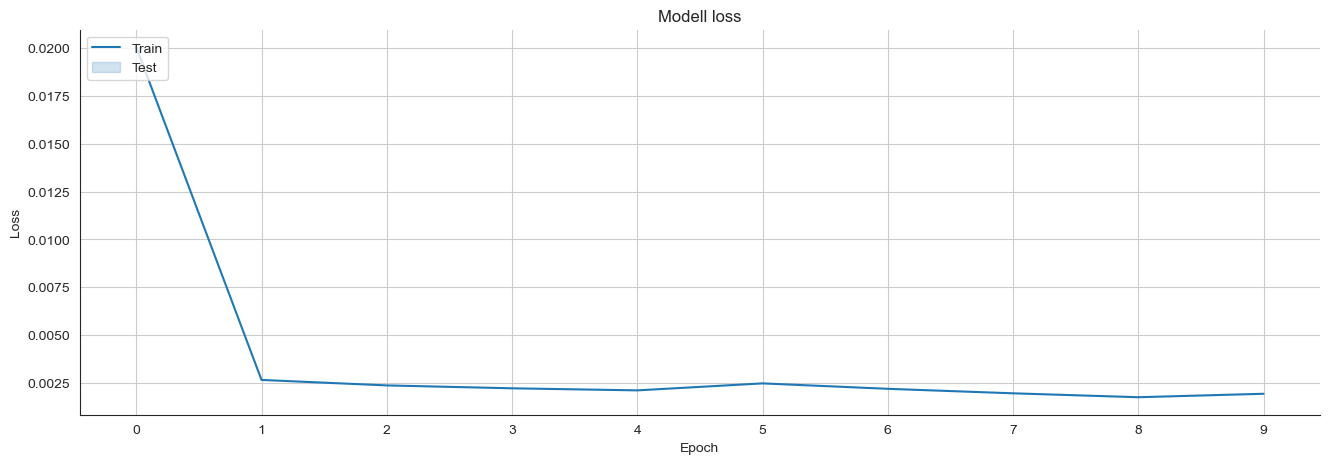

In [14]:
# Plotten der Trainings- und Loss-Werte

fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Modell loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

Es folgt die Rückskalierung

In [15]:
# Die predicted values
y_pred_scaled = model.predict(x_test)

# Skalierung der predicted values entfernen
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

5/5 [==============================] - 1s 23ms/step


Als nächstes werden die Vorhersagen für den nächsten Tag basierend auf dem trainierten Modell erstellt.

In [16]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

1/1 [==============================] - 0s 22ms/step


In [17]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Die letzten N Close-Werte der Tage erhalten und die Daten auf Werte zwischen 0 und 1 skalieren
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Eine leere Liste erstellen und vergangene N Tage hinzufügen
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Das X_test-Dataset in ein Numpy-Array konvertieren und die Daten umformen
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

1/1 [==============================] - 0s 28ms/step


Es wird eine Schleife für 30 Tage durchlaufen, die die Vorhersagen für die nächsten 30 Tage erstellt und die Ergebnisse dem DataFrame hinzufügt.

In [18]:
# Anzahl der nächsten Tage, die vorhergesagt werden sollen
num_days = 30

# Vorhersage für jeden Tag treffen und zum DataFrame hinzufügen
for _ in range(num_days):
    # Aktuelle letzten N Tage abrufen und skalieren
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Leere Liste erstellen und vergangene N Tage hinzufügen
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # X_test in ein Numpy-Array umwandeln und Daten umformen
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    # Vorhersage der nächsten 30 Tage speichern
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    
    # Datum für den nächsten Tag berechnen
    next_day = new_df.index[-1] + pd.DateOffset(days=1)
    
    # Vorhersage zum DataFrame hinzufügen
    df.loc[next_day, 'Predicted Price'] = predicted_price
    
    # Neuen Tag zum new_df DataFrame hinzufügen
    new_df.loc[next_day] = predicted_price
    
    # Aktuellen Tag aus dem DataFrame entfernen
    new_df = new_df[1:]

1/1 [==============================] - 0s 22ms/step


Nun wird ein Linienplot-Diagramm erzeugt, das den Verlauf der Spalte "Close" über die Zeit zeigt. Dies ermöglicht eine visuelle Darstellung der Entwicklung der Schlusskurse.

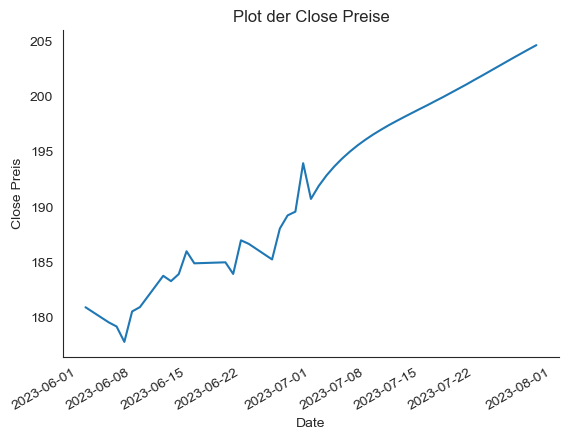

In [19]:
import matplotlib.pyplot as plt

# Plot der "Close" Werte
new_df["Close"].plot()

# Hinzufügen von labels und Titel
plt.xlabel("Date")
plt.ylabel("Close Preis")
plt.title("Plot der Close Preise")

# Displaying the plot
plt.show()


Es werden Transformationen vorgenommen, die es ermöglichen die Vorhersagedaten mit den tatsächlichen Daten zu vergleichen und zu visualisieren.

In [20]:
# Werte auf NaN setzen
start_date_from = end_date
new_df.loc[start_date_from:, ["Open", "High", "Low", "Volume"]] = np.nan
new_df['Date'] = new_df.index
# Key einbinden
#company = data.loc[0]['Company']
new_df['Company'] = company_name
new_df['Type'] = new_df['High'].apply(lambda x: f'LSTM_{company_name}' if np.isnan(x) else f'Act_{company_name}')
new_df.loc[new_df['Type'].str.contains('LSTM'), 'Forecast_Date'] = end_date
new_df['Key'] = new_df['Company'] + '_' + new_df['Date'].astype(str) + '_' + new_df['Type']
new_df = new_df[~new_df["Type"].str.contains("Act_")]

Eine Verbindung zur Datenbank wird hergestellt und bestehende Daten aus einer Tabelle in einen DataFrame geladen. Dabei werden die Daten an den vorhandenen DataFrame `data_extended_key` angepasst und eine neue Spalte "Key" erstellt, um die Vorhersagedaten eindeutig zu identifizieren.

In [21]:
import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import warnings

# Deaktivieren der Pandas-Warnungen
warnings.filterwarnings('ignore', category=UserWarning)

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Query erstellen, um alle Daten auszulesen
query = "SELECT * FROM stock_data_forecast WHERE [TYPE] LIKE 'LSTM_%'"

# Ausführen der Query und Laden der Ergebnisse in einen DataFrame
exists_df = pd.read_sql(query, cnxn)

# added
exists_df = exists_df.astype(new_df.dtypes)
exists_df = exists_df.reindex(columns=new_df.columns)

# Key einbinden
exists_df['Key'] = exists_df['Company'] + '_' + exists_df['Date'].astype(str) + '_' + exists_df['Type']

Der Code führt das Zusammenführen der Vorhersagedaten mit den vorhandenen Daten durch und schreibt den aktualisierten DataFrame in die SQL Server-Tabelle. Dabei werden Duplikate entfernt und die Anzahl der geschriebenen Zeilen wird angezeigt.

In [22]:
# added
exists_df = exists_df.astype(new_df.dtypes)
exists_df = exists_df.reindex(columns=new_df.columns)

# Zusammenführen der beiden DataFrames
combined_df = pd.concat([new_df, exists_df])

# Entfernen von Duplikaten
combined_df = combined_df.drop_duplicates(subset=['Key'], keep=False)

# Schreiben des aktualisierten DataFrames in die SQL Server-Tabelle
combined_df.to_sql('stock_data_forecast', con=engine, if_exists='append', index=False)

# Anzahl der geschriebenen Zeilen erhalten
num_written_rows = combined_df.shape[0]
print(f"Es wurden {num_written_rows} Zeilen erfolgreich übertragen.")

exists_df = pd.read_sql('SELECT * FROM stock_data_forecast', cnxn)
exists_df.drop_duplicates(subset='Key', inplace=True)

# Verbindung schließen
cnxn.close()
print(f"Die Verbindung ist wieder geschlossen.")

Es wurden 0 Zeilen erfolgreich übertragen.
Die Verbindung ist wieder geschlossen.


In [23]:
combined_df

,High,Low,Open,Close,Volume,Date,Company,Type,Forecast_Date,Key
